In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader as pdr

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['GOOG', 'MSFT', 'SPY']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2012-10-01'
end_date = '2022-10-01'

#df = yf.Ticker('goog').history(interval='15m', start='2012-09-10', end='2022-09-10')
df = pdr.DataReader(tickers, 'yahoo', start_date, end_date)
df

Attributes   Adj Close                               Close              \
Symbols           GOOG        MSFT         SPY        GOOG        MSFT   
Date                                                                     
2012-10-01   18.973383   24.118446  119.590256   18.973383   29.490000   
2012-10-02   18.854080   24.257486  119.714523   18.854080   29.660000   
2012-10-03   18.991316   24.421059  120.203354   18.991316   29.860001   
2012-10-04   19.129547   24.560089  121.064934   19.129547   30.030001   
2012-10-05   19.119585   24.412876  121.073219   19.119585   29.850000   
...                ...         ...         ...         ...         ...   
2022-09-26   98.809998  236.782700  364.309998   98.809998  237.449997   
2022-09-27   98.089996  235.745636  363.380005   98.089996  236.410004   
2022-09-28  100.739998  240.392548  370.529999  100.739998  241.070007   
2022-09-29   98.089996  236.832565  362.790009   98.089996  237.500000   
2022-09-30   96.150002  232.245483  357.179993   96.150002  232.899994   

Attributes                    High                                Low  \
Symbols            SPY        GOOG        MSFT         SPY       GOOG   
Date                                                                    
2012-10-01  144.350006   19.053581   29.980000  145.690002  18.834654   
2012-10-02  144.500000   19.078239   29.889999  145.149994  18.686708   
2012-10-03  145.089996   19.026684   29.990000  145.429993  18.734777   
2012-10-04  146.130005   19.175377   30.030001  146.339996  18.914104   
2012-10-05  146.139999   19.287207   30.250000  147.160004  19.053831   
...                ...         ...         ...         ...        ...   
2022-09-26  364.309998  100.440002  241.449997  370.209991  98.379997   
2022-09-27  363.380005  100.459999  241.800003  370.399994  97.339996   
2022-09-28  370.529999  101.400002  242.330002  372.299988  97.800003   
2022-09-29  362.790009   99.300003  239.949997  367.109985  96.519997   
2022-09-30  357.179993   99.494003  240.539993  365.910004  96.029999   

Attributes                               Open                          \
Symbols           MSFT         SPY       GOOG        MSFT         SPY   
Date                                                                    
2012-10-01   29.420000  144.009995  18.905388   29.809999  144.520004   
2012-10-02   29.500000  143.830002  19.058563   29.680000  144.919998   
2012-10-03   29.670000  144.130005  18.822449   29.750000  144.889999   
2012-10-04   29.570000  145.440002  18.997543   29.969999  145.639999   
2012-10-05   29.740000  145.699997  19.195799   30.230000  146.910004   
...                ...         ...        ...         ...         ...   
2022-09-26  236.899994  363.029999  98.610001  237.050003  366.410004   
2022-09-27  234.500000  360.869995  99.910004  239.979996  368.019989   
2022-09-28  234.729996  362.600006  98.019997  236.809998  364.380005   
2022-09-29  234.410004  359.700012  99.300003  238.889999  366.809998   
2022-09-30  232.729996  357.040009  97.730003  238.289993  361.799988   

Attributes       Volume                           
Symbols            GOOG        MSFT          SPY  
Date                                              
2012-10-01  127194978.0  54042700.0  135911200.0  
2012-10-02  112026334.0  43338900.0  113422200.0  
2012-10-03   88663090.0  46655900.0  121283100.0  
2012-10-04   98535958.0  43634900.0  124311600.0  
2012-10-05  109846193.0  41133900.0  124842100.0  
...                 ...         ...          ...  
2022-09-26   22437900.0  27694200.0   92581200.0  
2022-09-27   24225000.0  27018700.0  108294100.0  
2022-09-28   24617000.0  29029700.0  110802200.0  
2022-09-29   21921500.0  27484200.0  112952300.0  
2022-09-30   26277800.0  35694800.0  153711200.0  

[2517 rows x 18 columns]

In [2]:
# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = df['Close']

# Getting all weekdays between 01/01/2000 and 12/31/2016
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
close = close.reindex(all_weekdays)

# Reindexing will insert missing values (NaN) for the dates that were not present
# in the original set. To cope with this, we can fill the missing by replacing them
# with the latest available price for each instrument.
close = close.fillna(method='ffill')

close.dropna(inplace=True)
close.describe()

Symbols,GOOG,MSFT,SPY
count,2610.000000,2610.000000,2610.000000
mean,57.315619,116.419954,267.808567
std,35.232347,88.917631,87.413459
min,16.119081,26.370001,135.699997
25%,28.843434,46.102499,201.937500
50%,48.638000,75.185001,247.970001
75%,69.699627,173.962502,312.807487
max,150.709000,343.109985,477.709991


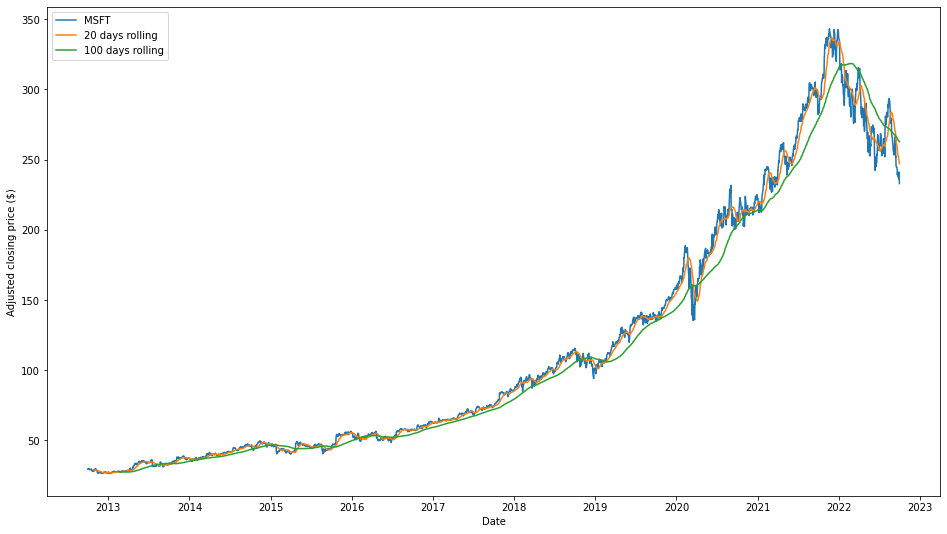

In [3]:
def visualize_equity(df, index):
    # Get the MSFT timeseries. This now returns a Pandas Series object indexed by date.
    idx = df.loc[:, index]

    # Calculate the 20 and 100 days moving averages of the closing prices
    short_rolling_idx = idx.rolling(window=20).mean()
    long_rolling_idx = idx.rolling(window=100).mean()

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(16,9))

    ax.plot(idx.index, idx, label=index)
    ax.plot(short_rolling_idx.index, short_rolling_idx, label='20 days rolling')
    ax.plot(long_rolling_idx.index, long_rolling_idx, label='100 days rolling')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price ($)')
    ax.legend()
    plt.show()

visualize_equity(close, 'MSFT')

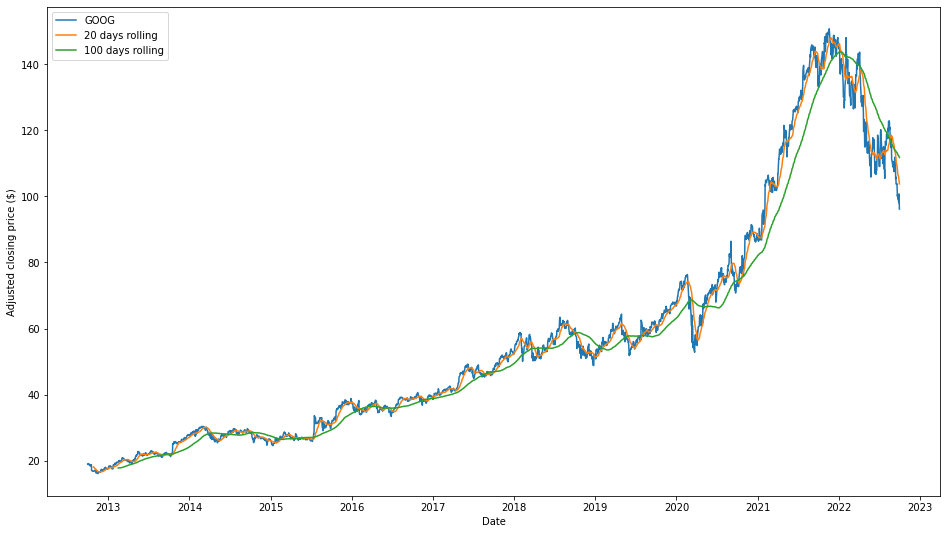

In [4]:
visualize_equity(close, 'GOOG')

In [ ]:
visualize_equity(close, 'SPY')

In [ ]:
data=close.copy()

# Identify dates as datetimes
def str_to_datetime(s):
        import datetime
        split = s.split('-')
        year, month, day = int(split[0]), int(split[1]), int(split[2])
        return datetime.datetime(year=year, month=month, day=day)

if (data.index.dtype != '' and data.index.dtype != 'datetime64[ns]'):
    data.reset_index(inplace=True)
    data['Date'] = df['Date'].apply(str_to_datetime)
else: 
    print('Date is already Datetime')

In [ ]:
close['MSFT']

In [ ]:
# Start day second time around: '2021-03-25'
df=pd.DataFrame(close['MSFT'])
X_timesteps=3
start_date='2017-10-01'
end_date='2022-10-01'

# Phrase the data as the info considered in a daily window of time
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # n is the number of timesteps (X)
    import numpy as np
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

windowed_df = df_to_windowed_df(df,start_date,end_date,n=X_timesteps)
windowed_df

In [ ]:
# Splits the df into three cruicial tensor components: (the date, input, target)
def windowed_df_to_date_X_y(windowed_dataframe, number_of_y_vars=1):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0] #dates kept in first column, not as index

    middle_matrix = df_as_np[:, 1:-number_of_y_vars] #all x (after dates, before y)
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], number_of_y_vars))

    Y = df_as_np[:, -number_of_y_vars:]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

In [ ]:
# Split for 80% train, 10% validation, 10% test
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',  
                optimizer=Adam(learning_rate=0.001), 
                metrics=['mean_absolute_error','root_mean_squared_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])